In [1]:
import os, sys
import numpy as np
import torch
import json

sys.path.append("..")
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.data import NormalDataProvider

In [2]:
CONTENT_PATH = "/home/xianglin/projects/DVI_data/resnet18_cifar10"
VIS_METHOD = "DVI"
sys.path.append(CONTENT_PATH)

In [3]:
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    conf = json.load(f)
config = conf[VIS_METHOD]

# record output information
# now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
# sys.stdout = open(os.path.join(CONTENT_PATH, now+".txt"), "w")

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]

# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")


In [4]:
import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES,verbose=1)


Finish initialization...


In [5]:
# inspired by
# https://github.com/yuanli2333/CKA-Centered-Kernel-Alignment/blob/master/CKA.py

import math
import torch
import numpy as np

class CKA(object):
    def __init__(self):
        pass 
    
    def centering(self, K):
        n = K.shape[0]
        unit = np.ones([n, n])
        I = np.eye(n)
        H = I - unit / n
        return np.dot(np.dot(H, K), H) 

    def rbf(self, X, sigma=None):
        GX = np.dot(X, X.T)
        KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
        if sigma is None:
            mdist = np.median(KX[KX != 0])
            sigma = math.sqrt(mdist)
        KX *= - 0.5 / (sigma * sigma)
        KX = np.exp(KX)
        return KX
 
    def kernel_HSIC(self, X, Y, sigma):
        return np.sum(self.centering(self.rbf(X, sigma)) * self.centering(self.rbf(Y, sigma)))

    def linear_HSIC(self, X, Y):
        L_X = X @ X.T
        L_Y = Y @ Y.T
        return np.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self, X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = np.sqrt(self.linear_HSIC(X, X))
        var2 = np.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2)

    def kernel_CKA(self, X, Y, sigma=None):
        hsic = self.kernel_HSIC(X, Y, sigma)
        var1 = np.sqrt(self.kernel_HSIC(X, X, sigma))
        var2 = np.sqrt(self.kernel_HSIC(Y, Y, sigma))

        return hsic / (var1 * var2)

    
class CudaCKA(object):
    def __init__(self, device):
        self.device = device
    
    def centering(self, K):
        n = K.shape[0]
        unit = torch.ones([n, n], device=self.device)
        I = torch.eye(n, device=self.device)
        H = I - unit / n
        return torch.matmul(torch.matmul(H, K), H)  

    def rbf(self, X, sigma=None):
        GX = torch.matmul(X, X.T)
        KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
        if sigma is None:
            mdist = torch.median(KX[KX != 0])
            sigma = math.sqrt(mdist)
        KX *= - 0.5 / (sigma * sigma)
        KX = torch.exp(KX)
        return KX

    def kernel_HSIC(self, X, Y, sigma):
        return torch.sum(self.centering(self.rbf(X, sigma)) * self.centering(self.rbf(Y, sigma)))

    def linear_HSIC(self, X, Y):
        L_X = torch.matmul(X, X.T)
        L_Y = torch.matmul(Y, Y.T)
        return torch.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self, X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = torch.sqrt(self.linear_HSIC(X, X))
        var2 = torch.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2)

    def kernel_CKA(self, X, Y, sigma=None):
        hsic = self.kernel_HSIC(X, Y, sigma)
        var1 = torch.sqrt(self.kernel_HSIC(X, X, sigma))
        var2 = torch.sqrt(self.kernel_HSIC(Y, Y, sigma))
        return hsic / (var1 * var2)

In [6]:
device = torch.device('cuda:1')
cuda_cka = CudaCKA(device)

# X = torch.from_numpy(data_provider.train_representation(20)[:5000]).to(device=device, dtype=torch.float)
# Y = torch.from_numpy(data_provider.train_representation(50)[:5000]).to(device=device, dtype=torch.float)

# print('Linear CKA, between X and Y: {}'.format(cuda_cka.linear_CKA(X, Y)))
# print('Linear CKA, between X and X: {}'.format(cuda_cka.linear_CKA(X, X)))

# print('RBF Kernel CKA, between X and Y: {}'.format(cuda_cka.kernel_CKA(X, Y)))
# print('RBF Kernel CKA, between X and X: {}'.format(cuda_cka.kernel_CKA(X, X)))

In [8]:
sim_m = np.zeros((199,199))
for i in range(2, 201):
    for j in range(i, 201):
        X = torch.from_numpy(data_provider.train_representation(i)[:5000]).to(device=device, dtype=torch.float)
        Y = torch.from_numpy(data_provider.train_representation(j)[:5000]).to(device=device, dtype=torch.float)
        sim_m[i-2, j-2] = cuda_cka.linear_CKA(X, Y)
        sim_m[j-2, i-2] = sim_m[i-2, j-2]

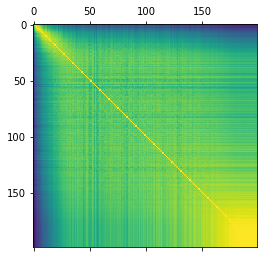

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# a 2D array with linearly increasing values on the diagonal
plt.matshow(sim_m)

plt.show()

In [10]:
np.save("/home/xianglin/projects/git_space/DLVisDebugger/experiments/cifar10_sim.npy", sim_m)

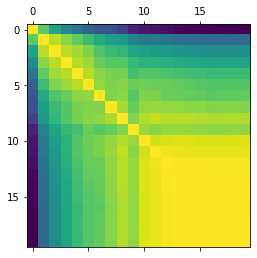

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# a 2D array with linearly increasing values on the diagonal
plt.matshow(sim_m)

plt.show()

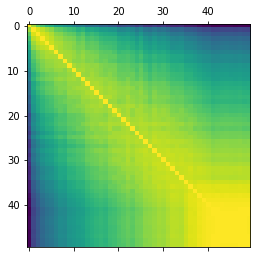

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# a 2D array with linearly increasing values on the diagonal
plt.matshow(sim_m)

plt.show()